In [ ]:
import pandas as pd
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import xgboost as xgb

import numpy as np

  ### Preprocessing

In [ ]:
!pip install yfinance

!pip install hpbandster-sklearn

In [ ]:
# Load data
import yfinance as yf

btcdata = yf.download("ETH-USD", start="2020-04-01", end="2022-04-07")
df = pd.DataFrame(btcdata)
df.drop(columns=['Adj Close'],inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-01,133.612320,135.634552,129.730942,135.634552,12456564435
2020-04-02,135.732178,146.787094,135.732178,142.029144,15322861686
2020-04-03,142.110458,146.899872,139.619385,142.091309,13184603402
2020-04-04,142.215179,145.377304,140.121826,145.219391,11946658257
2020-04-05,145.261017,146.128525,142.102081,143.546646,11280993591
...,...,...,...,...,...
2022-04-03,3444.810547,3573.960205,3421.259766,3522.833496,15333808649
2022-04-04,3522.364990,3535.148193,3422.000977,3521.241211,18209969743
2022-04-05,3521.239746,3546.706787,3410.547607,3411.792480,16681503199


In [ ]:
df['Open']=df.Open.shift(-15)
df['High']=df.High.shift(-15)
df['Low']=df.Low.shift(-15)
df['Volume']=df.Low.shift(-15)
df.dropna(inplace=True)
X=df.copy()
X.drop("Close", axis=1, inplace=True)
X

,Open,High,Low,Volume
Date,,,,
2020-04-01,153.200424,173.157272,150.359421,207.780884
2020-04-02,172.279419,174.275909,169.751572,212.878677
2020-04-03,171.618073,187.940475,171.618073,208.692368
2020-04-04,186.861984,188.098923,180.120819,199.047729
2020-04-05,181.480225,186.083542,170.321274,204.031128
...,...,...,...,...
2022-03-04,2944.721680,2979.987061,2910.802246,3421.259766
2022-03-05,2946.547607,2956.965576,2826.107422,3422.000977
2022-03-06,2860.103271,2954.556641,2838.250488,3410.547607


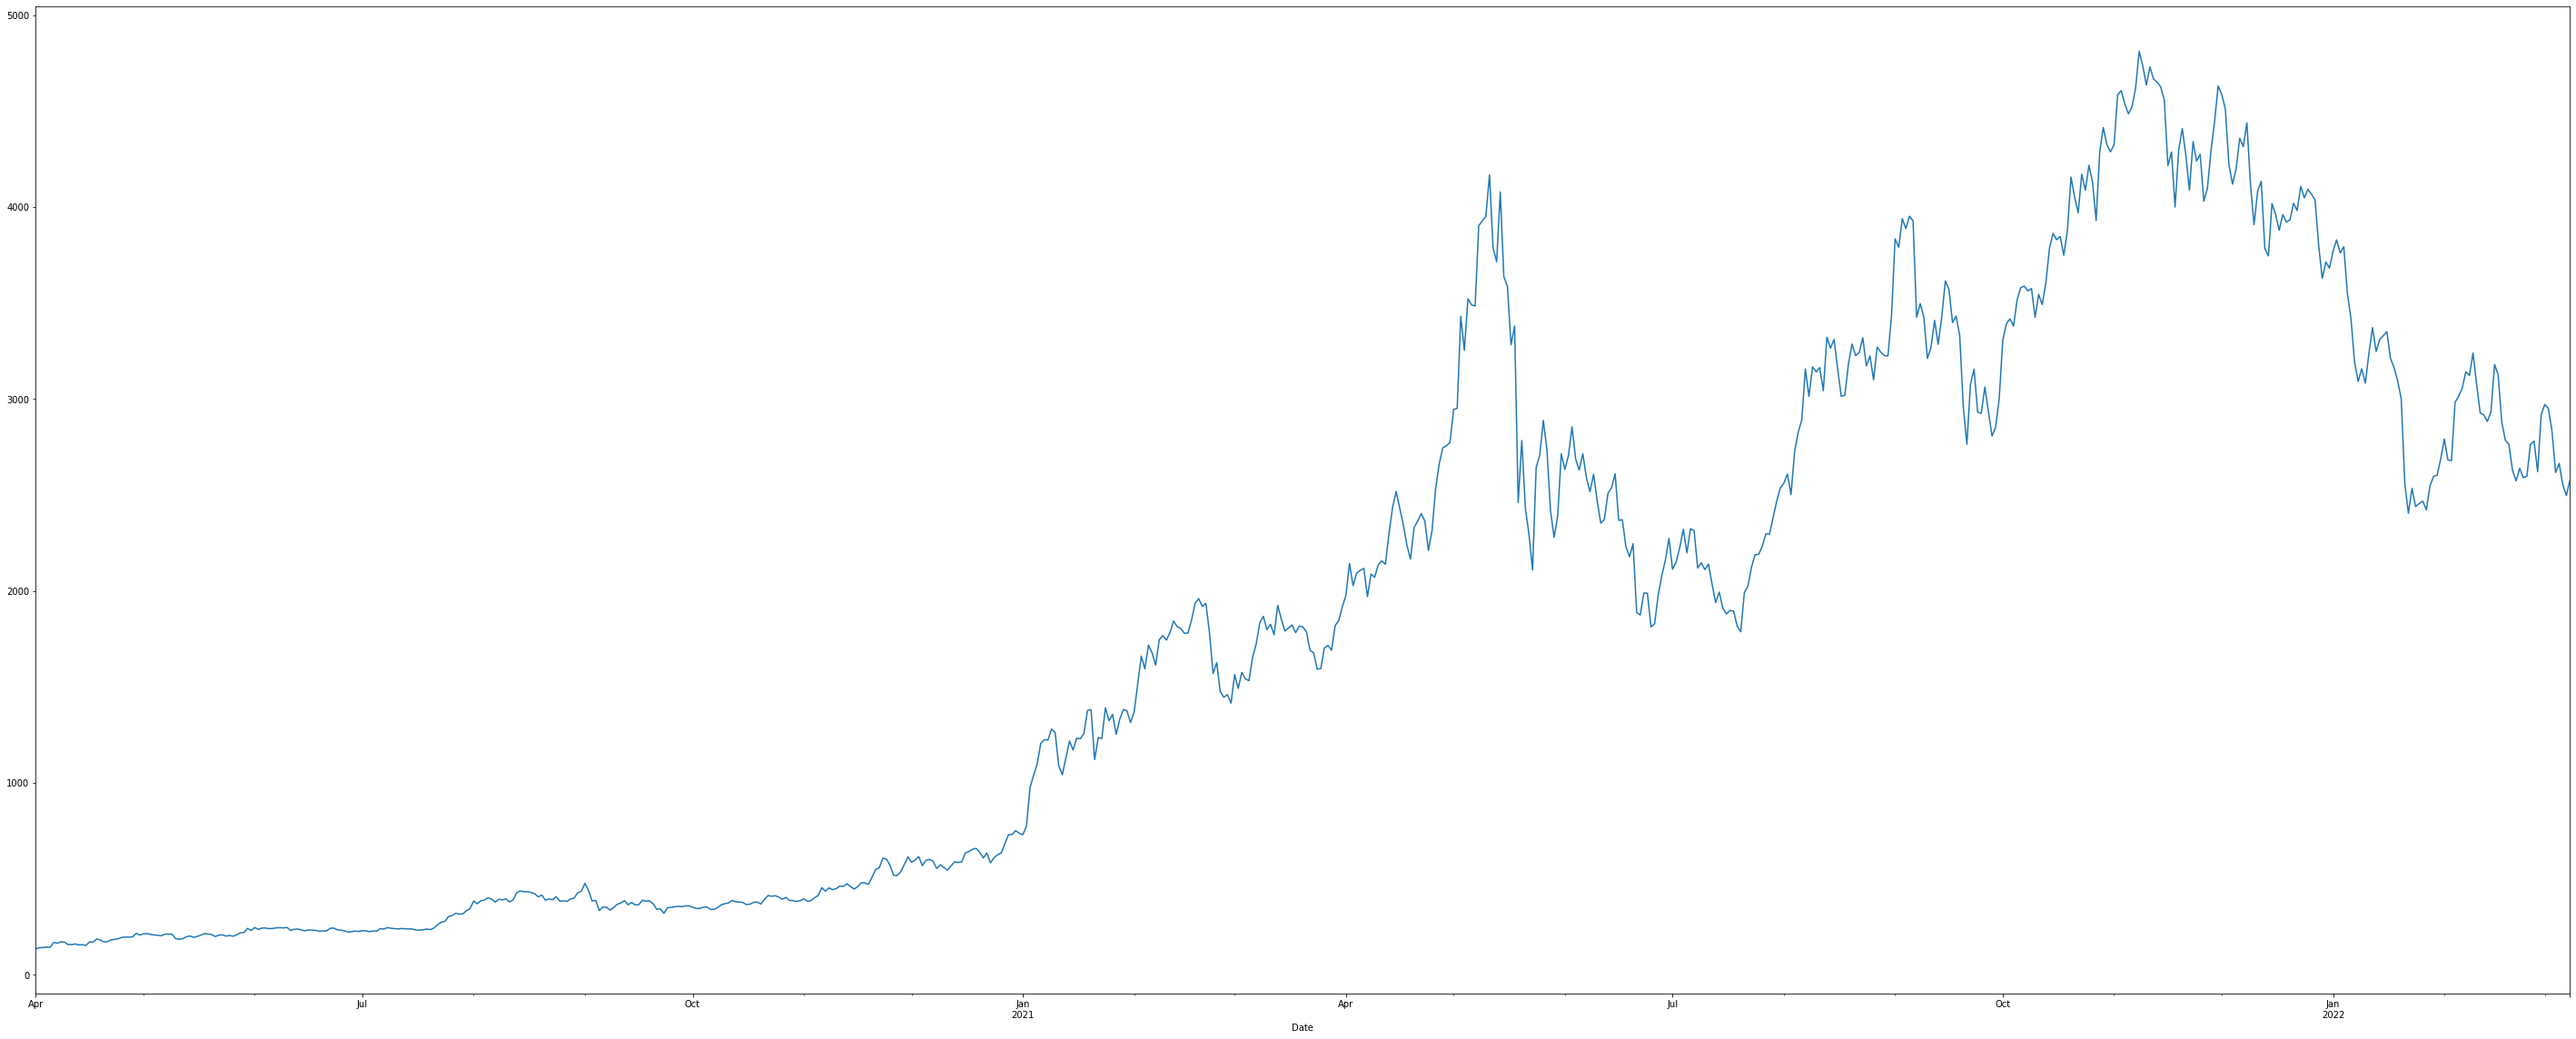

In [ ]:
# Define target vector
y = df.Close
df.Close.plot(figsize=(50, 20))


In [ ]:
# Splitting into Train and Test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
pd.DataFrame(y_test)

,Close
Date,
2021-08-08,3013.732666
2021-08-09,3167.856201
2021-08-10,3141.691162
2021-08-11,3164.245117
2021-08-12,3043.414307
...,...
2022-03-04,2617.156006
2022-03-05,2664.831055
2022-03-06,2555.037354


  ### Choose best learning rate

  ### Create Gradient Boosting Classifier

In [ ]:
from hpbandster_sklearn import HpBandSterSearchCV

param_distributions = {"max_depth": list(range(1, 10)), "learning_rate":[0,0.25,.5,.75,1]}
model = xgb.XGBRegressor(objective ='reg:linear')



search = HpBandSterSearchCV(model, param_distributions,random_state=0, n_jobs=1, n_iter=10, verbose=1).fit(X_train_scaled, y_train.ravel())
search.best_params_

WORKER: start listening for jobs
HBMASTER: adjusted queue size to (0, 1)
HBMASTER: starting run at 1650076365.3198798
WORKER: start processing job (0, 0, 0)
WORKER: registered result for job (0, 0, 0) with dispatcher
WORKER: start processing job (0, 0, 1)
WORKER: registered result for job (0, 0, 1) with dispatcher
WORKER: start processing job (0, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbt

WORKER: registered result for job (0, 0, 2) with dispatcher
WORKER: start processing job (0, 0, 3)
WORKER: registered result for job (0, 0, 3) with dispatcher
WORKER: start processing job (0, 0, 4)
WORKER: registered result for job (0, 0, 4) with dispatcher
WORKER: start processing job (0, 0, 5)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree

WORKER: registered result for job (0, 0, 5) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [3, 3] has EI value inf
data in the KDEs:
[[1. 7.]
 [4. 1.]
 [0. 4.]]
[[0. 1.]
 [0. 5.]
 [0. 6.]]
bandwidth of the KDEs:
[1.50020661 2.16202784]
[1.00000000e-03 1.90672933e+00]
l(x) = 0.8108721143531382
g(x) = inf
WORKER: start processing job (0, 0, 6)
WORKER: registered result for job (0, 0, 6) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 3] has EI value inf
data in the KDEs:
[[1. 7.]
 [3. 3.]
 [4. 1.]]
[[0. 4.]
 [0. 1.]
 [0. 5.]
 [0. 6.]]
bandwidth of the KDEs:
[1.10085069 2.20170138]
[1.00000000e-03 1.57397038e+00]
l(x) = -0.055510776

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: start processing job (0, 0, 8)
WORKER: registered result for job (0, 0, 8) with dispatcher
WORKER: start processing job (0, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (0, 0, 0) with dispatcher
WORKER: start processing job (0, 0, 7)
WORKER: registered result for job (0, 0, 7) with dispatcher
WORKER: start processing job (0, 0, 8)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (0, 0, 8) with dispatcher
WORKER: start processing job (0, 0, 7)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (0, 0, 7) with dispatcher
WORKER: start processing job (1, 0, 0)
WORKER: registered result for job (1, 0, 0) with dispatcher
WORKER: start processing job (1, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (1, 0, 1) with dispatcher
WORKER: start processing job (1, 0, 2)
WORKER: registered result for job (1, 0, 2) with dispatcher


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: start processing job (1, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (1, 0, 0) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
sampled vector: [1, 4] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (2, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (2, 0, 0) with dispatcher
WORKER: start processing job (2, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (2, 0, 1) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
sampled vector: [1, 8] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (2, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (2, 0, 2) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 0] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (3, 0, 0)
WORKER: registered result for job (3, 0, 0) with dispatcher
WORKER: start processing job (3, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 1) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 8] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (3, 0, 2)
WORKER: registered result for job (3, 0, 2) with dispatcher


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
sampled vector: [3, 1] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.13869415039783442
g(x) = inf
WORKER: start processing job (3, 0, 3)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 3) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 6] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (3, 0, 4)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 4) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 2] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.5812189092348223
g(x) = inf
WORKER: start processing job (3, 0, 5)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 5) with dispatcher
WORKER: start processing job (3, 0, 6)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 6) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [1, 1] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.2618684058247642
g(x) = inf
WORKER: start processing job (3, 0, 7)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 7) with dispatcher
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:64: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
sampled vector: [2, 1] has EI value inf
data in the KDEs:
[[1. 3.]
 [0. 1.]
 [1. 7.]]
[[0. 7.]
 [0. 3.]
 [0. 3.]]
bandwidth of the KDEs:
[0.41608245 2.20170138]
[1.0000000e-03 1.6643298e+00]
l(x) = 0.13869415039783442
g(x) = inf
WORKER: start processing job (3, 0, 8)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 8) with dispatcher
WORKER: start processing job (3, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 1) with dispatcher
WORKER: start processing job (3, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 2) with dispatcher
WORKER: start processing job (3, 0, 8)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 8) with dispatcher
WORKER: start processing job (3, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (3, 0, 2) with dispatcher
WORKER: start processing job (4, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (4, 0, 0) with dispatcher
WORKER: start processing job (4, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (4, 0, 1) with dispatcher
WORKER: start processing job (4, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (4, 0, 2) with dispatcher
WORKER: start processing job (4, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (4, 0, 2) with dispatcher
WORKER: start processing job (5, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (5, 0, 0) with dispatcher
WORKER: start processing job (5, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (5, 0, 1) with dispatcher
WORKER: start processing job (5, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (5, 0, 2) with dispatcher
WORKER: start processing job (6, 0, 0)
WORKER: registered result for job (6, 0, 0) with dispatcher
WORKER: start processing job (6, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 1) with dispatcher
WORKER: start processing job (6, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 2) with dispatcher
WORKER: start processing job (6, 0, 3)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 3) with dispatcher
WORKER: start processing job (6, 0, 4)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 4) with dispatcher
WORKER: start processing job (6, 0, 5)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 5) with dispatcher
WORKER: start processing job (6, 0, 6)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 6) with dispatcher
WORKER: start processing job (6, 0, 7)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 7) with dispatcher
WORKER: start processing job (6, 0, 8)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 8) with dispatcher
WORKER: start processing job (6, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 0) with dispatcher
WORKER: start processing job (6, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 1) with dispatcher
WORKER: start processing job (6, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 2) with dispatcher
WORKER: start processing job (6, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (6, 0, 1) with dispatcher
WORKER: start processing job (7, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (7, 0, 0) with dispatcher
WORKER: start processing job (7, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (7, 0, 1) with dispatcher
WORKER: start processing job (7, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (7, 0, 2) with dispatcher
WORKER: start processing job (7, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.75, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (7, 0, 1) with dispatcher
WORKER: start processing job (8, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (8, 0, 0) with dispatcher
WORKER: start processing job (8, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (8, 0, 1) with dispatcher
WORKER: start processing job (8, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (8, 0, 2) with dispatcher
WORKER: start processing job (9, 0, 0)
WORKER: registered result for job (9, 0, 0) with dispatcher


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: start processing job (9, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 1) with dispatcher
WORKER: start processing job (9, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 2) with dispatcher
WORKER: start processing job (9, 0, 3)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.5, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 3) with dispatcher
WORKER: start processing job (9, 0, 4)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 4) with dispatcher
WORKER: start processing job (9, 0, 5)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 5) with dispatcher
WORKER: start processing job (9, 0, 6)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 6) with dispatcher
WORKER: start processing job (9, 0, 7)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 7) with dispatcher
WORKER: start processing job (9, 0, 8)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 8) with dispatcher
WORKER: start processing job (9, 0, 0)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 0) with dispatcher
WORKER: start processing job (9, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 1) with dispatcher
WORKER: start processing job (9, 0, 2)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0, 'max_delta_step': 0, 'max_depth': 1, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 2) with dispatcher
WORKER: start processing job (9, 0, 1)


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'warm_start': True}


WORKER: registered result for job (9, 0, 1) with dispatcher

Best score: -0.5137831221183291
Best found configuration: {'learning_rate': 0.25, 'max_depth': 9}
A total of 54 unique configurations where sampled.
A total of 73 runs where executed.
Total budget of resource 'n_estimators' corresponds to 27.000000000000014 full function evaluations.


[{'fit_error': None, 'test_scores': {'score': -3.420806808023003}, 'n_test_samples': 99, 'fit_time': 0.010006189346313477, 'score_time': 0.0005881786346435547}, {'fit_error': None, 'test_scores': {'score': 0.11905028403535167}, 'n_test_samples': 99, 'fit_time': 0.009514808654785156, 'score_time': 0.0005035400390625}, {'fit_error': None, 'test_scores': {'score': -0.18733419243659455}, 'n_test_samples': 99, 'fit_time': 0.009053468704223633, 'score_time': 0.0004570484161376953}, {'fit_error': None, 'test_scores': {'score': -1.0983424508983308}, 'n_test_samples': 99, 'fit_time': 0.00896453857421875, 'score_time': 0.0004417896270751953}, {'fit_error': None, 'test_scores': {'score': -1.0716697840362208}, 'n_test_samples': 98, 'fit_time': 0.008831024169921875, 'score_time': 0.0004875659942626953}, {'fit_error': None, 'test_scores': {'score': -4.662315741419269}, 'n_test_samples': 99, 'fit_time': 0.04793357849121094, 'score_time': 0.0008769035339355469}, {'fit_error': None, 'test_scores': {'sc

{'learning_rate': 0.25, 'max_depth': 9}

In [ ]:



# Choose a learning rate and create classifier
model = xgb.XGBRegressor(objective ='reg:linear', learning_rate = search.best_params_['learning_rate'],
                max_depth = search.best_params_['max_depth'], n_estimators = 100)

# Fit the model
model.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = model.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

[02:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Prediction,Actual
0,2404.240479,3013.732666
1,2473.459717,3167.856201
2,2655.831787,3141.691162
3,2502.587402,3164.245117
4,2397.026855,3043.414307
5,2509.301025,3322.211670
6,2504.095215,3265.443359
7,2513.656250,3310.504150
8,2594.523438,3156.509521
9,2649.340088,3014.845947


  ### Evaluate the model

In [ ]:
# Calculating the accuracy score
# acc_score = accuracy_score(y_test, predictions)
# print(f"Accuracy Score : {acc_score}")


stocks = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predictions.ravel()
    }, index = df.index[-len(y_test): ])
stocks.head(100)



,Real,Predicted
Date,,
2021-08-08,3013.732666,2404.240479
2021-08-09,3167.856201,2473.459717
2021-08-10,3141.691162,2655.831787
2021-08-11,3164.245117,2502.587402
2021-08-12,3043.414307,2397.026855
...,...,...
2021-11-11,4730.384277,2713.229980
2021-11-12,4667.115234,2998.551270
2021-11-13,4651.460449,2472.942627


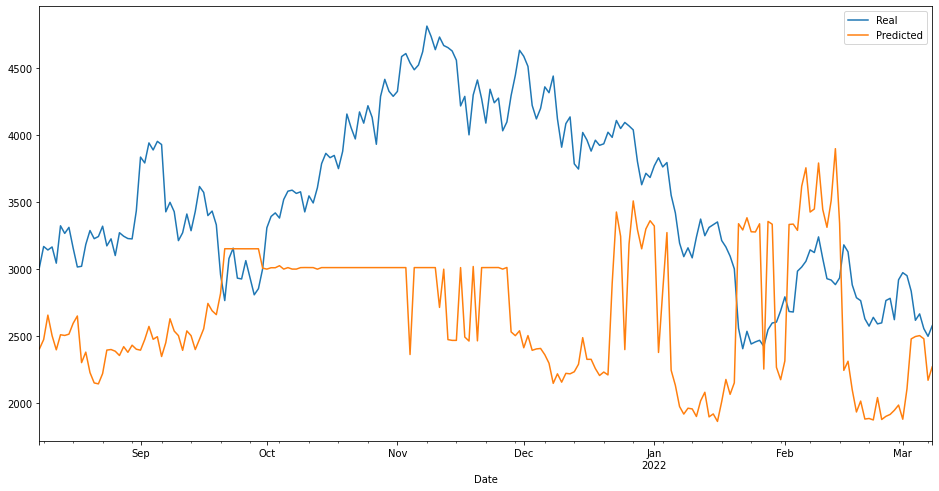

In [ ]:
stocks.plot(figsize = (16,8))

In [ ]:
from sklearn import metrics

print(f'Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions), 4))
print(f'Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions), 4))
print(f'Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print(f'(R^2) Score:', round(metrics.r2_score(y_test, predictions), 4))
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 993.7109
Mean Squared Error: 1263839.6693
Root Mean Squared Error: 1124.2062
(R^2) Score: -2.2939
Accuracy: 72.79 %.
